# Global Diferential Privacy Assessement: NeuroImaging

This is the final version of showcasing how our Global Differential Privacy can guaranty privacy when analyzing and sharing data.
After running this notebook, you will be able to:
- Understand the concept of Global Differential Privacy in the term of real-world Bids-like neuroimages.
- Apply Global Differential Privacy to images.

In [1]:
import os, sys, subprocess, wget, shutil

We download an image from a real study and prepare it to assess.

In [2]:
script = os.path.join(os.path.dirname(os.getcwd())+"/CalibrateNoise/", "main.py") 
file = "input/anat/original/"
clean = False

os.makedirs("img", exist_ok=True)
link_original = "https://s3.amazonaws.com/openneuro.org/ds004934/sub-SAXNES2s001/func/sub-SAXNES2s001_task-DOTS_run-001_bold.nii.gz?versionId=R0fwRS9fxw8CcPZnb4zYsw9I5v19aAbP"
wget.download(link_original)
os.makedirs(file, exist_ok=True)
file_ = [os.path.join(root, file) for root, _, files in os.walk(os.getcwd()) for file in files if file.endswith(".gz")]
shutil.copy2(file_[0], file)
os.remove(file_[0])
print(f"\nOriginal file downloaded.") 


100% [....................................................] 60545196 / 60545196
Original file downloaded.


In [5]:
result = subprocess.run(
    ["python3", script, file],
    capture_output=True,
    text=True
)
print(result.stdout)
if clean:
    ! rm -r input
    print(f"Cleaning up finished")  

========== ERN ==========

Total time taken: 00:01:03



# Related update from 16/09

# Data import and concatenating frames for MEEG
data in are 2D -- channels x frames
assemble per subjects -- channels x frames x subjects

to concatenate and estinate covariance --> channels x [subjects *frames]

ie repeat N subjects over frames (not all frames per subjects and subjects after each other)


# Cyril's mail

n 22 is the number of clusters -- but we decided to NOT use clusters because the labelling makes no sense

make a channel x channel dp noise matrix

for each channel, read upper triangle to find neighbourgh and compute dp, store results say in dimension 2

once all channels have been iterated, average covariance values resulting in channel noise vector 

In [180]:
from mne.channels import make_dig_montage

path = "/staff/vincentajoubi/Trash/wp15-chrono-T/usecase-2.4/input/sub-032/ses-ERN/eeg/"

channels_df = pd.read_csv(path + 'sub-032_ses-ERN_task-ERN_channels.tsv', sep='\t')
electrodes_df = pd.read_csv(path + 'sub-032_ses-ERN_task-ERN_electrodes.tsv', sep='\t')

merged_df = pd.merge(channels_df, electrodes_df, on='name')


eeg_json = {
    "TaskName": "ERN",
    "EEGReference": "CMS",
    "SamplingFrequency": 1024,
    "PowerLineFrequency": 60,
    "EEGPlacementScheme": "10-20"
}

montage = make_dig_montage(
    ch_pos={row['name']: [row['x'], row['y'], row['z']] 
            for _, row in merged_df.iterrows()},
    coord_frame='head'
)

info = mne.create_info(
    ch_names=merged_df['name'].tolist(),
    sfreq=eeg_json['SamplingFrequency'],
    ch_types='eeg'
)

info.set_montage(montage)

<Info | 8 non-empty values
 bads: []
 ch_names: FP1, F3, F7, FC3, C3, C5, P3, P7, P9, PO7, PO3, O1, Oz, Pz, CPz, ...
 chs: 33 EEG
 custom_ref_applied: False
 dig: 36 items (3 Cardinal, 33 EEG)
 highpass: 0.0 Hz
 lowpass: 512.0 Hz
 meas_date: unspecified
 nchan: 33
 projs: []
 sfreq: 1024.0 Hz
>

In [181]:
pos = np.array([info['chs'][i]['loc'][:3] for i in range(len(info['chs']))])

print(f"Closest neighbors:\n")
for i, ch1 in enumerate(names):
    distances = []
    for j, ch2 in enumerate(names):
        if i != j:
            dist = np.linalg.norm(pos[i] - pos[j]) * 1000
            distances.append((ch2, dist))

    distances.sort(key=lambda x: x[1])

    closest_neighbors = [f"{ch}" for ch,_ in distances[:4]]
    print(f"\t{ch1}: {', '.join(closest_neighbors)}")


Closest neighbors:

	FP1: FP2, F7, F3, Fz
	F3: FC3, F7, Fz, FP1
	F7: F3, FP1, C5, FC3
	FC3: F3, C3, C5, F7
	C3: FC3, C5, F3, P3
	C5: C3, FC3, F7, P7
	P3: PO3, PO7, P7, Pz
	P7: PO7, P9, P3, O1
	P9: P7, PO7, O1, PO3
	PO7: O1, P7, PO3, P9
	PO3: O1, P3, PO7, Oz
	O1: PO3, Oz, PO7, O2
	Oz: O1, O2, PO3, PO4
	Pz: CPz, P4, P3, PO3
	CPz: Cz, Pz, FCz, P4
	FP2: FP1, F8, F4, Fz
	Fz: FCz, F4, F3, Cz
	F4: FC4, Fz, F8, FP2
	F8: F4, FP2, C6, FC4
	FC4: F4, C4, C6, F8
	FCz: Cz, Fz, FC3, FC4
	Cz: CPz, FCz, Pz, Fz
	C4: FC4, C6, F4, P4
	C6: C4, FC4, F8, P8
	P4: PO4, PO8, Pz, P8
	P8: PO8, P10, P4, O2
	P10: P8, PO8, O2, PO4
	PO8: O2, P8, PO4, P10
	PO4: O2, P4, PO8, Oz
	O2: PO4, PO8, Oz, O1
	HEOG_left: FP1, F3, F7, FC3
	HEOG_right: FP1, F3, F7, FC3
	VEOG_lower: FP1, F3, F7, FC3


In [182]:
distance_matrix = np.zeros((len(names), len(names)))
for i in range(len(names)):
    for j in range(len(names)):
        if i != j:
            distance_matrix[i, j] = np.linalg.norm(pos[i] - pos[j])
        else:
            distance_matrix[i, j] = 0


distance_df = pd.DataFrame(distance_matrix, index=names, columns=names)
print(distance_df.round())  


              FP1     F3     F7    FC3     C3     C5     P3     P7     P9  \
FP1           0.0   54.0   52.0   82.0  108.0  102.0  147.0  137.0  135.0   
F3           54.0    0.0   52.0   31.0   62.0   68.0  115.0  119.0  131.0   
F7           52.0   52.0    0.0   64.0   82.0   62.0  119.0  100.0  101.0   
FC3          82.0   31.0   64.0    0.0   32.0   46.0   90.0  101.0  120.0   
C3          108.0   62.0   82.0   32.0    0.0   35.0   62.0   82.0  108.0   
C5          102.0   68.0   62.0   46.0   35.0    0.0   68.0   62.0   83.0   
P3          147.0  115.0  119.0   90.0   62.0   68.0    0.0   52.0   83.0   
P7          137.0  119.0  100.0  101.0   82.0   62.0   52.0    0.0   35.0   
P9          135.0  131.0  101.0  120.0  108.0   83.0   83.0   35.0    0.0   
PO7         151.0  134.0  120.0  116.0   94.0   82.0   47.0   27.0   44.0   
PO3         159.0  136.0  134.0  115.0   90.0   91.0   31.0   53.0   75.0   
O1          162.0  147.0  137.0  130.0  108.0  102.0   54.0   52.0   62.0   

In [213]:
def neighs(channel_name, radius=50):
    idx = names.index(channel_name)
    neighbors = []
    for j, other_channel in enumerate(names):
        if j != idx and distance_matrix[idx, j] <= radius:
            neighbors.append((other_channel, distance_matrix[idx, j]))
    
    neighbors.sort(key=lambda x: x[1])
    return neighbors

for channel in names:  
    neighbors = neighs(channel, 60)
    neighbor_str = ", ".join([f"{ch}" for ch, dist in neighbors])
    print(f"{channel}: {neighbor_str if neighbor_str else 'No neighbors'}")

FP1: FP2, F7, F3
F3: FC3, F7, Fz, FP1
F7: F3, FP1
FC3: F3, C3, C5
C3: FC3, C5
C5: C3, FC3
P3: PO3, PO7, P7, Pz, O1
P7: PO7, P9, P3, O1, PO3
P9: P7, PO7
PO7: O1, P7, PO3, P9, P3, Oz
PO3: O1, P3, PO7, Oz, Pz, P7
O1: PO3, Oz, PO7, O2, P7, P3
Oz: O1, O2, PO3, PO4, PO8, PO7
Pz: CPz, P4, P3, PO3, PO4
CPz: Cz, Pz
FP2: FP1, F8, F4
Fz: FCz, F4, F3
F4: FC4, Fz, F8, FP2
F8: F4, FP2
FC4: F4, C4, C6
FCz: Cz, Fz
Cz: CPz, FCz
C4: FC4, C6
C6: C4, FC4
P4: PO4, PO8, Pz, P8, O2
P8: PO8, P10, P4, O2, PO4
P10: P8, PO8
PO8: O2, P8, PO4, P10, P4, Oz
PO4: O2, P4, PO8, Oz, Pz, P8
O2: PO4, PO8, Oz, O1, P8, P4
HEOG_left: No neighbors
HEOG_right: No neighbors
VEOG_lower: No neighbors


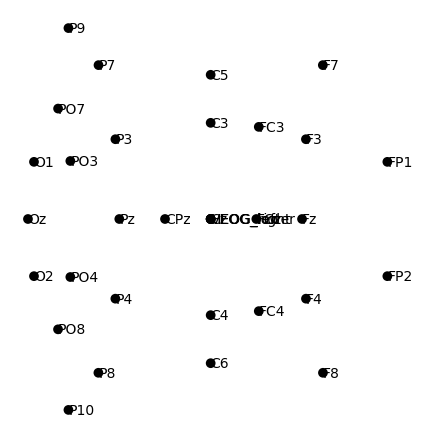

In [201]:
info = mne.create_info(ch_names=merged_df['name'].tolist(), sfreq=1024, ch_types='eeg')
info.set_montage(montage)

fig = plt.figure(figsize=(15, 12))

ax1 = fig.add_subplot(221)
mne.viz.plot_sensors(info, show_names=True, axes=ax1, title='Top View')
ax1.set_title('Top View', fontsize=14, fontweight='bold')
plt.show()

Down here I'm loading just one task(ERN) for all subjects.

so at the end variable all_values has the shape 39 which refers to task ERN for each subject.


In [38]:
from src.loader import fetch_files

tasks = ["ERN","LRP","MMN","N2pc","N170","N400","P3"]
task_order = {task: idx for idx, task in enumerate(tasks)}
def task_(path):
    for task in tasks:
        if f"_task-{task}_" in path or f"/ses-{task}/" in path:
            return task
    return None 

path = "/staff/vincentajoubi/wp15-chrono-T/usecase-2.4/input/"
path_list = fetch_files(path).vhdr_()
path_list_sorted = sorted(path_list, key=lambda x: task_order.get(task_(x), float('inf')))
path_list_sorted = [[path for path in path_list_sorted if task in path] for task in tasks] # each index refers to a task for all subjects

all_values = list()
for path_list in path_list_sorted:
    for path in path_list:
        raw = mne.io.read_raw_brainvision(path, preload=True).get_data()
        all_values.append(raw)
    break

#test = np.empty(len(all_values), dtype=object)
#for i, arr in enumerate(all_values):
#    test[i] = arr

The visualization below shows one channel for each subject, where y-axis shows time or length of the channel. 

There 33 channels, so assume for each bar in the plot, it is extended by 33.

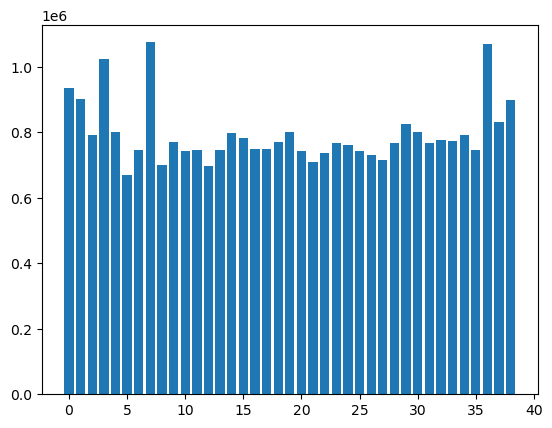

In [89]:
import matplotlib.pyplot as plt

plt.bar([i for i in range(len(all_values))], [i.shape[1] for i in all_values])
plt.show()

Here I have taken time t of each subject in each channel and compute the covariance. So the data input to calculate cov is (39, 33) up until all subject has time t in common.

In [207]:
try:
    print(f"Max val along all channels: {np.max([subject.shape[1] for subject in all_values])}")
    for time in range(np.max([subject.shape[1] for subject in all_values])):
        if time % 100000 == 0:
            print(time, np.mean(np.cov(np.vstack([subject[:, time] for subject in all_values]))))
except IndexError: pass

Max val along all channels: 1074176
0 6647618.984755068
100000 7650665.771170235
200000 6433670.322630599
300000 6281892.719030941
400000 6715212.918483125
500000 6130087.805620784
600000 5902844.025179543


In [ ]:
# file:///users/vincentajoubi/Downloads/ERP%20CORE,%20All%20Files.pdf